In [1]:
import sys
sys.path.append('../..')
import wandb
from data import load_data_strasb
from model_configs import build_model
from sklearn.linear_model import RidgeClassifier
from meco import MECO
from models import GCN, train_lens, test_lens
import os
import joblib
from scipy.io import arff
import pandas as pd
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
import torch
import torch_explain as te
from torch.nn.functional import one_hot
from torch_explain.logic.nn import entropy
from torch_explain.logic.metrics import test_explanation, complexity
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, Sequential
from torch_geometric.utils.convert import from_networkx
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from torch_geometric.utils import to_undirected, add_remaining_self_loops
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import networkx as nx
from torch.nn.functional import one_hot, leaky_relu


In [2]:
models = ['GCN', 'RF', 'DT']
# models = ['GCN', 'DT']

# load data
x, y, is_control, fnames, cnames = load_data_strasb(data_path='../../data/strasb/')

sss = StratifiedShuffleSplit(n_splits=10, random_state=42)
sss.get_n_splits(x, y)

10

In [3]:
results = pd.DataFrame([], columns=['Model', 'Model Error (%)', 'Explanation Error (%)', 'Explanation Complexity (log)'])
expl_pd = pd.DataFrame([], columns=['Fold', 'Accuracy (%)', 'Complexity', 'Explanation'])
fimps = {m: np.zeros(x.shape[1]) for m in models}
for split, (train_index, test_index) in enumerate(sss.split(x, y)):
#     if split > 3:
#         break
    for model_name in models:
        model_path = os.path.join('./stras-artifacts', str(split), model_name)
        skb = SelectKBest(f_classif, k=100)
        skb.fit(x[train_index], y[train_index])
        x_new = skb.transform(x)
        x_new = torch.FloatTensor(x_new)
        if model_name == 'GCN':
            expl = joblib.load(os.path.join('./stras-artifacts', str(split), "explanations.pkl"))
#             m = GCN(x.shape[1], 50, len(torch.unique(y)))
            m = torch.load(os.path.join(model_path, "model.pth"))
            fimp = m.lens.alpha_norm.median(dim=0)[0].detach().numpy()
            exp_acc = np.median([e['explanation_accuracy'] for e in expl.values() if isinstance(e, dict)])
            exp_comp = np.sum([e['explanation_complexity'] for e in expl.values() if isinstance(e, dict)])
            results.loc[len(results)] = ['Logic Explained Net', 1-expl['f1'], 1-exp_acc, np.log(exp_comp)]
            cn = np.array(list(set(cnames)))
            for c in range(len(np.unique(y))):
                exp = expl[str(c)]
                rule = cn[c] + ' \leftarrow ' + expl[str(c)]['explanation'].replace('&', '\land').replace('|', '\lor').replace('_N', '').replace('~', '\\neg ')
                rule = rule.replace("\n", "")
                print(rule)
                expl_pd.loc[len(expl_pd)] = [f'${split+1}$', f'${exp["explanation_accuracy"].item()*100:.2f}$', f'${exp["explanation_complexity"].item()}$', f'${rule}$']
#             break
            
        elif model_name == 'DT':
            model = joblib.load(os.path.join(model_path, "model.pkl"))
            y_pred = model.predict(x_new[test_index])
            f1 = f1_score(y[test_index], y_pred, average='weighted')
            n_nodes = model.tree_.node_count
            fimp = model.feature_importances_
            results.loc[len(results)] = ['Decision Tree', 1-f1, 1-f1, np.log(n_nodes)]
        else:
            model = joblib.load(os.path.join(model_path, "model.pkl"))
            y_pred = model.predict(x_new[test_index])
            f1 = f1_score(y[test_index], y_pred, average='weighted')
            fimp = model.feature_importances_
            n_count = 0
            for est in model.estimators_:
                n_count += est.tree_.node_count
            results.loc[len(results)] = ['Random Forest', 1-f1, 1-f1, np.log(n_count)]
            
        fimps[model_name][skb.get_support()] = fimps[model_name][skb.get_support()] + fimp
fimps = pd.DataFrame(fimps)
fimps = fimps / fimps.max(axis=0)
fimps.index = fnames
fimps

mem=1 \leftarrow ENSMUSG00000000031 \land ENSMUSG00000000247 \land ENSMUSG00000000253 \land \neg ENSMUSG00000000301
mem=-1 \leftarrow ENSMUSG00000000037 \lor \neg ENSMUSG00000000157 \lor \neg ENSMUSG00000000167 \lor \neg ENSMUSG00000000317
mem=1 \leftarrow ENSMUSG00000000028 \land ENSMUSG00000000402 \land \neg ENSMUSG00000000346
mem=-1 \leftarrow \neg ENSMUSG00000000126 \lor \neg ENSMUSG00000000215 \lor \neg ENSMUSG00000000339 \lor \neg ENSMUSG00000000560
mem=1 \leftarrow ENSMUSG00000000171 \land ENSMUSG00000000244 \land \neg ENSMUSG00000000296
mem=-1 \leftarrow ENSMUSG00000000532 \lor \neg ENSMUSG00000000320 \lor \neg ENSMUSG00000000374
mem=1 \leftarrow ENSMUSG00000000489 \land \neg ENSMUSG00000000167 \land \neg ENSMUSG00000000184
mem=-1 \leftarrow ENSMUSG00000000167 \lor ENSMUSG00000000244 \lor \neg ENSMUSG00000000001 \lor \neg ENSMUSG00000000378
mem=1 \leftarrow ENSMUSG00000000359 \land ENSMUSG00000000552 \land \neg ENSMUSG00000000120 \land \neg ENSMUSG00000000263
mem=-1 \leftarrow 

,GCN,RF,DT
ENSMUSG00000000001,0.0,0.0,0.0
ENSMUSG00000000028,0.0,0.0,0.0
ENSMUSG00000000031,0.0,0.0,0.0
ENSMUSG00000000037,0.0,0.0,0.0
ENSMUSG00000000049,0.0,0.0,0.0
...,...,...,...
ENSMUSG00000114268,0.0,0.0,0.0
ENSMUSG00000114548,0.0,0.0,0.0
ENSMUSG00000115388,0.0,0.0,0.0
ENSMUSG00000116246,0.0,0.0,0.0


In [44]:
results

,Model,Model Error (%),Explanation Error (%),Explanation Complexity (log)
0,Logic Explained Net,0.333333,0.166667,2.079442
1,Random Forest,0.185185,0.185185,6.467699
2,Decision Tree,0.185185,0.185185,1.609438
3,Logic Explained Net,0.000000,0.166667,1.945910
4,Random Forest,0.000000,0.000000,6.416732
5,Decision Tree,0.000000,0.000000,1.609438
6,Logic Explained Net,0.000000,0.250000,1.791759
7,Random Forest,0.000000,0.000000,6.432940
8,Decision Tree,0.466667,0.466667,1.609438
9,Logic Explained Net,0.000000,0.583333,1.945910


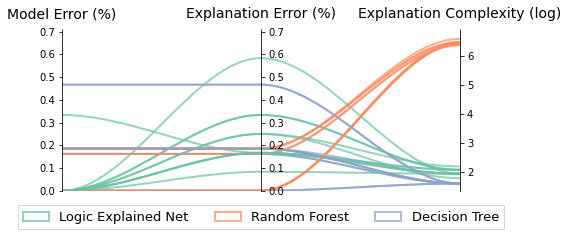

In [7]:
from matplotlib.path import Path
import matplotlib.patches as patches

result_dir = './stras-results/figs_base'
os.makedirs(result_dir, exist_ok=True)

model_id = {'Logic Explained Net': 0, 'Random Forest': 1, 'Decision Tree': 2}
# model_id = {'Logic Explained Net': 0, 'Decision Tree': 1}
ynames = ['Model Error (%)', 'Explanation Error (%)', 'Explanation Complexity (log)']
ys = results.values[:, 1:]
ymins = ys.min(axis=0)
ymaxs = ys.max(axis=0)
dys = ymaxs - ymins
ymins -= dys * 0.05  # add 5% padding below and above
ymaxs += dys * 0.05

# ymaxs[1], ymins[1] = ymins[1], ymaxs[1]  # reverse axis 1 to have less crossings
ymaxs[0], ymins[0] = 0.7, 0.
ymaxs[1], ymins[1] = 0.7, 0.
dys = ymaxs - ymins

# transform all data to be compatible with the main axis
zs = np.zeros_like(ys)
zs[:, 0] = ys[:, 0]
zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]

fig, host = plt.subplots(figsize=(8,3.5))

axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))

host.set_xlim(0, ys.shape[1] - 1)
host.set_xticks(range(ys.shape[1]))
host.set_xticklabels(ynames, fontsize=14)
host.tick_params(axis='x', which='major', pad=7)
host.spines['right'].set_visible(False)
host.xaxis.tick_top()
# host.set_title('Parallel Coordinates Plot — Iris', fontsize=18, pad=12)

my_cmap = matplotlib.colors.ListedColormap(plt.cm.Set2.colors[:3], name='my_colormap_name')
colors = my_cmap.colors
model_ids = [model_id[i] for i in results['Model'].values]
legend_handles = [None for _ in model_ids]
for j in range(ys.shape[0]):
    # create bezier curves
    verts = list(zip([x for x in np.linspace(0, len(ys) - 1, len(ys) * 3 - 2, endpoint=True)],
                     np.repeat(zs[j, :], 3)[1:-1]))
    codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=2, alpha=0.7, edgecolor=colors[model_ids[j]])
    legend_handles[model_ids[j]] = patch
    host.add_patch(patch)
host.legend(legend_handles, model_id.keys(),
            loc='lower center', bbox_to_anchor=(0.5, -0.28),
            ncol=len(model_id.keys()), fancybox=False, shadow=False, fontsize=13)
plt.tight_layout()
plt.savefig(os.path.join(result_dir, 'pareto.png'), facecolor='white', transparent=False)
plt.savefig(os.path.join(result_dir, 'pareto.pdf'), facecolor='white', transparent=False)
plt.show()

In [48]:
expl_pd.to_csv(os.path.join(result_dir, 'explanations.csv'))

In [4]:
total = fimps.sum(axis=1)
sort_idx = total.argsort(total)[::-1].values
fimps = fimps.iloc[sort_idx]
fimps.columns = ['Logic Explained Net', 'Random Forest', 'Decision Tree']
# fimps.columns = ['Logic Explained Net', 'Decision Tree']

In [8]:
fimps.to_csv(os.path.join(result_dir, 'feature_ranking.csv'))

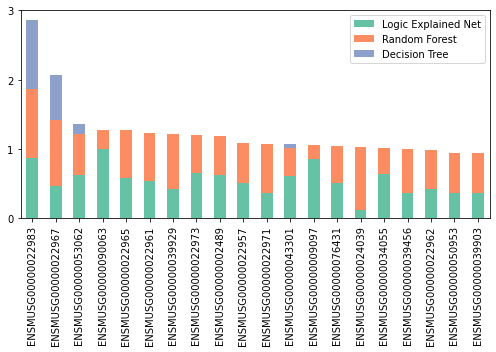

In [53]:
# Plot the total crashes
colors = plt.cm.Set2.colors
# f, ax = plt.subplots(figsize=(6, 18))
sns.set_color_codes("pastel")
# sns.barplot(x=total[sort_idx], y=fn[sort_idx], label="Total", color="b", alpha=0.3)
# sns.barplot(data=feat, stacked=True)
ax = fimps.iloc[:20].plot(kind='bar', stacked=True, figsize=(7, 5), colormap=my_cmap)
ax.set_ylim([0, 3])
ax.set_yticks([0, 1, 2, 3])
# ax.set_yticklabels([0, 1, 2, 3])
# sns.barplot(x=model.feature_importances_[sort_idx], y=fn[sort_idx], label="DT", color=colors[model_id['DT']])
plt.tight_layout()
plt.savefig(os.path.join(result_dir, 'feature_importance.png'), facecolor='white', transparent=False)
plt.savefig(os.path.join(result_dir, 'feature_importance.pdf'), facecolor='white', transparent=False)
plt.show()